In [1]:
#importing libraries
import os
import json
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', 200)


In [2]:
#Setting of datasetfile
ROOT = os.getcwd()
RAW = os.path.join(ROOT, "data", "raw")
PROC = os.path.join(ROOT, "data", "processed")
os.makedirs(RAW, exist_ok=True)
os.makedirs(PROC, exist_ok=True)


In [3]:
#Loading of datasets
fn = os.path.join(RAW, "aqi.csv")
assert os.path.exists(fn), f"File not found: {fn} - put your aqi.csv in data/raw/"

df = pd.read_csv(fn)
print("shape:", df.shape)
df.head(15)                  #It will show 15 cities weather data

shape: (235785, 9)


,date,state,area,number_of_monitoring_stations,prominent_pollutants,aqi_value,air_quality_status,unit,note
0,30-04-2025,Maharashtra,Amravati,2,PM10,78,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN
1,30-04-2025,Bihar,Purnia,1,CO,56,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN
2,30-04-2025,Madhya Pradesh,Katni,1,O3,98,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN
3,30-04-2025,Chhattisgarh,Tumidih,1,PM10,103,Moderate,number_of_monitoring_stations in Absolute Numb...,NaN
4,30-04-2025,Assam,Byrnihat,1,PM2.5,61,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN
5,30-04-2025,Manipur,Imphal,1,SO2,106,Moderate,number_of_monitoring_stations in Absolute Numb...,NaN
6,30-04-2025,Kerala,Kollam,1,PM10,73,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN
7,30-04-2025,West Bengal,Barrackpore,1,PM10,68,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN
8,30-04-2025,Odisha,Nayagarh,1,PM10,58,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN
9,30-04-2025,Assam,Nalbari,1,PM10,39,Good,number_of_monitoring_stations in Absolute Numb...,NaN


In [4]:
# Exploration of the dataset
print("Shape of Dataset:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\n--- Dataset Info ---")
print(df.info())
print("\n--- Statistical Summary ---")
print(df.describe())


Shape of Dataset: (235785, 9)

First 5 Rows:
          date           state      area  number_of_monitoring_stations  \
0  30-04-2025     Maharashtra  Amravati                              2   
1  30-04-2025           Bihar    Purnia                              1   
2  30-04-2025  Madhya Pradesh     Katni                              1   
3  30-04-2025    Chhattisgarh   Tumidih                              1   
4  30-04-2025           Assam  Byrnihat                              1   

  prominent_pollutants  aqi_value air_quality_status  \
0                 PM10         78       Satisfactory   
1                   CO         56       Satisfactory   
2                   O3         98       Satisfactory   
3                 PM10        103           Moderate   
4                PM2.5         61       Satisfactory   

                                                unit  note  
0  number_of_monitoring_stations in Absolute Numb...   NaN  
1  number_of_monitoring_stations in Absolute Numb.

In [5]:
#Checking missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- Missing Values ---
date                                  0
state                                 0
area                                  0
number_of_monitoring_stations         0
prominent_pollutants                  0
aqi_value                             0
air_quality_status                    0
unit                                  0
note                             235785
dtype: int64


In [6]:
#Checking for missing dates
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')

print("Missing dates:", df['date'].isna().sum())

df = df.dropna(subset=['date', 'aqi_value']).copy()
df = df.sort_values('date').reset_index(drop=True)


df['aqi_value'] = pd.to_numeric(df['aqi_value'], errors='coerce')
df['number_of_monitoring_stations'] = pd.to_numeric(df['number_of_monitoring_stations'], errors='coerce')


Missing dates: 0


In [7]:
#Setting of datetime and hourly aggregation
try:
    df
except NameError:
    # Create a sample DataFrame with some data
    df = pd.DataFrame({
        'number_of_monitoring_stations': np.random.randint(1, 10, 100),
        'aqi_value': np.random.randint(0, 500, 100)
    })

if 'date' not in df.columns:
    
    df['date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='h')

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df = df.set_index('date')

df_hourly = df[['number_of_monitoring_stations', 'aqi_value']].resample('h').mean()
df_hourly['hour'] = df_hourly.index.hour
df_hourly = df_hourly.interpolate(method='time', limit_direction='forward')

df_hourly.head()

,number_of_monitoring_stations,aqi_value,hour
date,,,
2022-04-01 00:00:00,1.953020,146.691275,0
2022-04-01 01:00:00,1.952511,146.495257,1
2022-04-01 02:00:00,1.952001,146.299239,2
2022-04-01 03:00:00,1.951491,146.103221,3
2022-04-01 04:00:00,1.950982,145.907203,4


In [8]:
#outlier capping and stats
def cap_iqr(s, factor=1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - factor * iqr
    high = q3 + factor * iqr
    return s.clip(lower=low, upper=high)

df_hourly['aqi_value'] = cap_iqr(df_hourly['aqi_value'])
df_hourly['number_of_monitoring_stations'] = cap_iqr(df_hourly['number_of_monitoring_stations'])

df_hourly.describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_monitoring_stations,27001.0,1.870058,0.045234,1.751977,1.840171,1.869183,1.898967,1.987160
aqi_value,27001.0,110.781017,37.014191,47.519481,79.332015,109.422283,138.760636,214.012245
hour,27001.0,11.499574,6.922540,0.000000,5.000000,11.000000,17.000000,23.000000


In [9]:
#Feature Engineering
df_feat = df_hourly.reset_index().rename(columns={'date':'datetime'}) if 'datetime' not in df_hourly.columns else df_hourly.reset_index()

if 'datetime' not in df_feat.columns:
    df_feat = df_feat.rename(columns={'date':'datetime'})

# Datetime features
df_feat['hour'] = df_feat['datetime'].dt.hour
df_feat['dayofweek'] = df_feat['datetime'].dt.dayofweek
df_feat['month'] = df_feat['datetime'].dt.month
df_feat['is_weekend'] = df_feat['dayofweek'].isin([5,6]).astype(int)

# Rolling features (AQI)
for w in [3, 24]:
    df_feat[f'aqi_roll_mean_{w}'] = df_feat['aqi_value'].rolling(window=w, min_periods=1).mean()
    df_feat[f'aqi_roll_std_{w}']  = df_feat['aqi_value'].rolling(window=w, min_periods=1).std().fillna(0)

# Lag features
df_feat['aqi_lag_1'] = df_feat['aqi_value'].shift(1)
df_feat['aqi_lag_24'] = df_feat['aqi_value'].shift(24)

# Station lags
df_feat['stations_lag_1'] = df_feat['number_of_monitoring_stations'].shift(1)
df_feat['stations_lag_24'] = df_feat['number_of_monitoring_stations'].shift(24)


df_feat = df_feat.dropna().reset_index(drop=True)

print("Feature columns:", df_feat.columns.tolist())
df_feat.head()

Feature columns: ['datetime', 'number_of_monitoring_stations', 'aqi_value', 'hour', 'dayofweek', 'month', 'is_weekend', 'aqi_roll_mean_3', 'aqi_roll_std_3', 'aqi_roll_mean_24', 'aqi_roll_std_24', 'aqi_lag_1', 'aqi_lag_24', 'stations_lag_1', 'stations_lag_24']


,datetime,number_of_monitoring_stations,aqi_value,hour,dayofweek,month,is_weekend,aqi_roll_mean_3,aqi_roll_std_3,aqi_roll_mean_24,aqi_roll_std_24,aqi_lag_1,aqi_lag_24,stations_lag_1,stations_lag_24
0,2022-04-02 00:00:00,1.940789,141.986842,0,5,4,1,142.182860,0.196018,144.241050,1.386057,142.182860,146.691275,1.941299,1.953020
1,2022-04-02 01:00:00,1.939901,141.789683,1,5,4,1,141.986462,0.196589,144.044984,1.386138,141.986842,146.495257,1.940789,1.952511
2,2022-04-02 02:00:00,1.939012,141.592525,2,5,4,1,141.789683,0.197159,143.848871,1.386292,141.789683,146.299239,1.939901,1.952001
3,2022-04-02 03:00:00,1.938124,141.395366,3,5,4,1,141.592525,0.197159,143.652710,1.386513,141.592525,146.103221,1.939012,1.951491
4,2022-04-02 04:00:00,1.937235,141.198207,4,5,4,1,141.395366,0.197159,143.456502,1.386794,141.395366,145.907203,1.938124,1.950982


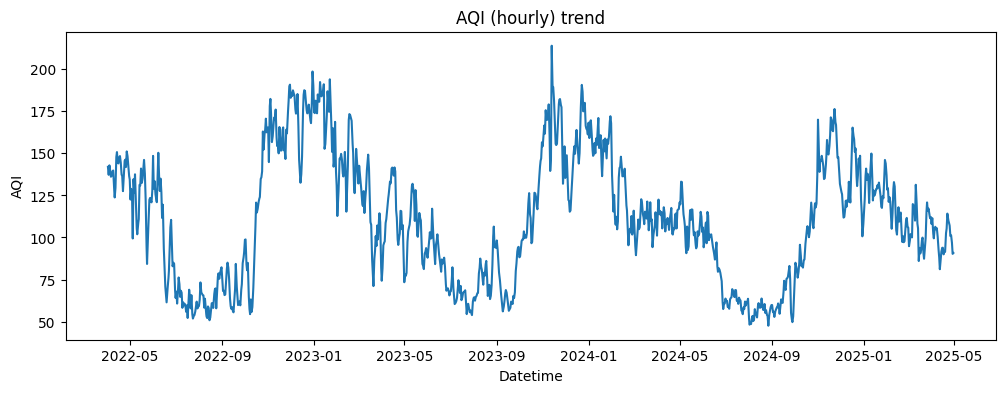

In [10]:
#Plotting 
plt.figure(figsize=(12,4))
plt.plot(df_feat['datetime'], df_feat['aqi_value'])
plt.title("AQI (hourly) trend")
plt.xlabel("Datetime")
plt.ylabel("AQI")
plt.show()

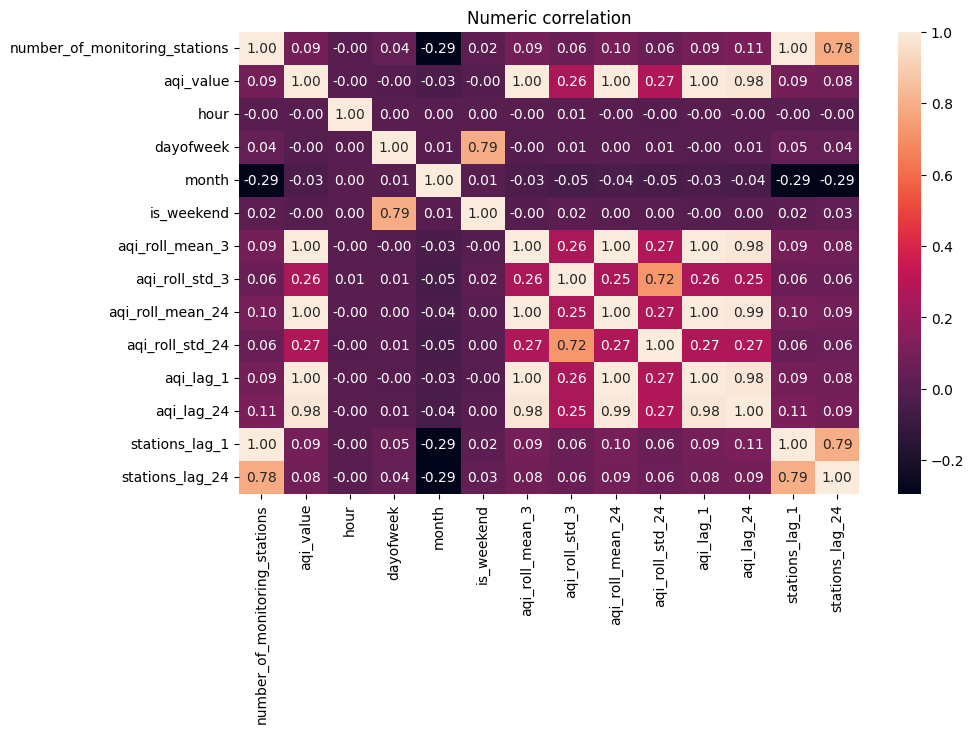

In [11]:
#Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_feat.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f")
plt.title("Numeric correlation")
plt.show()


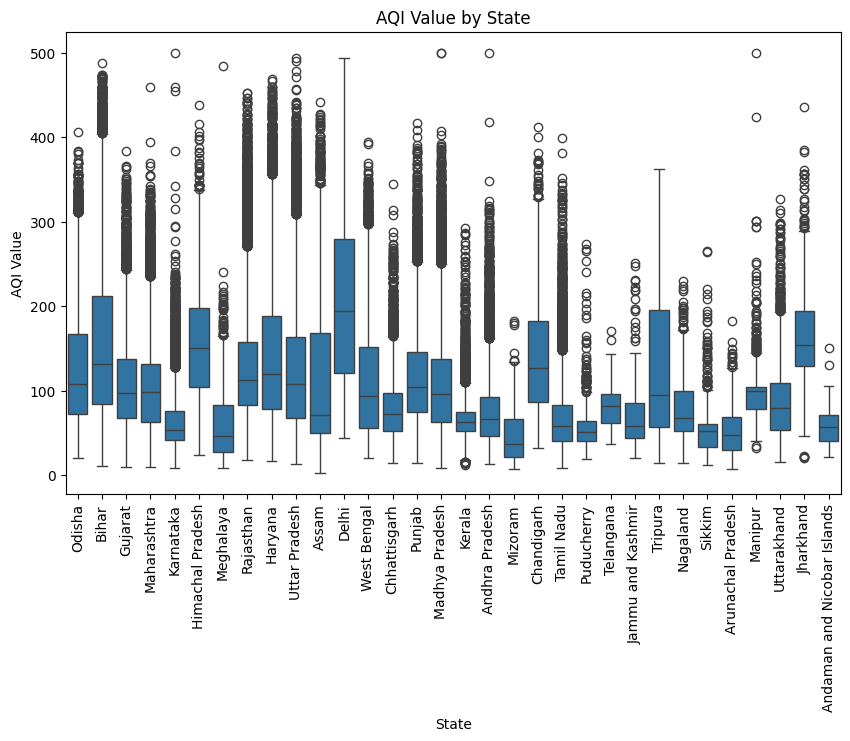

In [12]:
# Boxplot of AQI by state
plt.figure(figsize=(10, 6))
sns.boxplot(x='state', y='aqi_value', data=df)
plt.title('AQI Value by State')
plt.xlabel('State')
plt.ylabel('AQI Value')
plt.xticks(rotation=90)
plt.show()

In [13]:
#Preparing features/target (x/y)
drop_cols = ['datetime']  # plus 'note' if present
target = 'aqi_value'

for c in ['note','unit']:
    if c in df_feat.columns:
        drop_cols.append(c)

X = df_feat.drop(columns = drop_cols + [target], errors='ignore')
y = df_feat[target].copy()

print("X shape:", X.shape, "y shape:", y.shape)
X.head()


X shape: (26977, 13) y shape: (26977,)


,number_of_monitoring_stations,hour,dayofweek,month,is_weekend,aqi_roll_mean_3,aqi_roll_std_3,aqi_roll_mean_24,aqi_roll_std_24,aqi_lag_1,aqi_lag_24,stations_lag_1,stations_lag_24
0,1.940789,0,5,4,1,142.182860,0.196018,144.241050,1.386057,142.182860,146.691275,1.941299,1.953020
1,1.939901,1,5,4,1,141.986462,0.196589,144.044984,1.386138,141.986842,146.495257,1.940789,1.952511
2,1.939012,2,5,4,1,141.789683,0.197159,143.848871,1.386292,141.789683,146.299239,1.939901,1.952001
3,1.938124,3,5,4,1,141.592525,0.197159,143.652710,1.386513,141.592525,146.103221,1.939012,1.951491
4,1.937235,4,5,4,1,141.395366,0.197159,143.456502,1.386794,141.395366,145.907203,1.938124,1.950982


In [14]:
#Trainning,testing and splitting
split_idx = int(len(X) * 0.8)
X_train = X.iloc[:split_idx].copy()
X_test  = X.iloc[split_idx:].copy()
y_train = y.iloc[:split_idx].copy()
y_test  = y.iloc[split_idx:].copy()

print("Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0])


df_feat.to_csv(os.path.join(PROC, "aqi_preprocessed.csv"), index=False)
X_train.to_csv(os.path.join(PROC, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(PROC, "X_test.csv"), index=False)
y_train.to_csv(os.path.join(PROC, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(PROC, "y_test.csv"), index=False)


Train rows: 21581 Test rows: 5396


In [15]:
def create_preprocessor(X_train, X_test):
   
    # Identify column types
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ]), categorical_cols)
    ], remainder='drop')

    # Process data
    preprocessor.fit(X_train)
    X_train_prep = preprocessor.transform(X_train)
    X_test_prep = preprocessor.transform(X_test)
    
    # Save preprocessor
    joblib.dump(preprocessor, os.path.join(PROC, "preprocessor.joblib"))
    
    return X_train_prep, X_test_prep
print("Saved preprocessor.joblib")
    

Saved preprocessor.joblib


In [16]:
# Setting model directory
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)


In [17]:
# Generate synthetic data with fixed seed
np.random.seed(42)
X_train = np.random.rand(100, 5)
y_train = np.random.rand(100)
X_test = np.random.rand(20, 5)
y_test = np.random.rand(20)

In [18]:
# Preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Train model with hyperparameter tuning
def train_rf_model(X: np.ndarray, y: np.ndarray) -> RandomForestRegressor:
    """Train RandomForest with hyperparameter tuning."""
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    params = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10]
    }
    search = RandomizedSearchCV(
        rf, param_distributions=params, n_iter=6,
        cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_absolute_error',
        random_state=42, n_jobs=-1
    )
    search.fit(X, y)
    print(f"Best params: {search.best_params_}")
    return search.best_estimator_



In [20]:
# Trainning and evaluate
best_rf = train_rf_model(X_train_scaled, y_train)
y_pred = best_rf.predict(X_test_scaled)

Best params: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}


In [21]:
# Calculating metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*50)
print("RANDOM FOREST REGRESSION MODEL PERFORMANCE")
print("="*50)
print(f"Mean Squared Error (MSE):    {mse:.4f}")
print(f"Root Mean Squared Error:     {rmse:.4f}")
print(f"R² Score:                    {r2:.4f}")
print("="*50)



RANDOM FOREST REGRESSION MODEL PERFORMANCE
Mean Squared Error (MSE):    0.0966
Root Mean Squared Error:     0.3107
R² Score:                    -0.0607


In [22]:
# Save model
joblib.dump(best_rf, os.path.join(MODEL_DIR, "model_rf.joblib"))

['models\\model_rf.joblib']